This notebook is designed to show how to use the cratrcountr package to do Bayesian crater age calculations for the Moon using multiplication of full Poisson PDFs.

Here, we load the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta
from scipy import optimize
import time
import random
import pickle as pkl
from cratrcountr import *
%matplotlib inline

First, we load the example data.  In this case, the data are from Robbins et al. (2014) and provided by Stuart Robbins.  They come from LROC NAC image M146959973L.  The diameters are in units of pixels, and an adjustment is made for pixel size.  The area is an estimated area of the image.  It is not properly buffered, and it does not represent a clearly identified geologic unit per se.  These values are uncertain and could be wrong.  These data are for example pursposes only.

In [3]:
rawd = pd.read_csv('M146959973L.txt',delimiter='\t')*0.626608880720610
ds = np.array(sorted(rawd['D_wm'].tolist()))/1000
area = 4000*2215*0.626608880720610**2/1000000

Next, we plot the example data using the incremental left plot.  Here, we choose a bin width exponent of 0.25, so our bin edges follow the series 2^(0.25n).  In this case, we can see that the data appear saturated under equilibrium saturation, so we have to choose which bins to use and which bins to exclude.  (NOTE: These data are in the diameter range where quasi-equilibrium effects are negligible, D<5km.)  One of the bins appears in gray because it is a bin with no craters in it.  Under Poisson statistics, a zero-crater bin still provides chronology information, and it cannot be ignored.  In fact, as we will soon see, we will have to incorporate the information we gain from having no craters larger than our largest bin.  However, if we were plotting with only zero-crater bins, we would have to be extremely careful about priors.

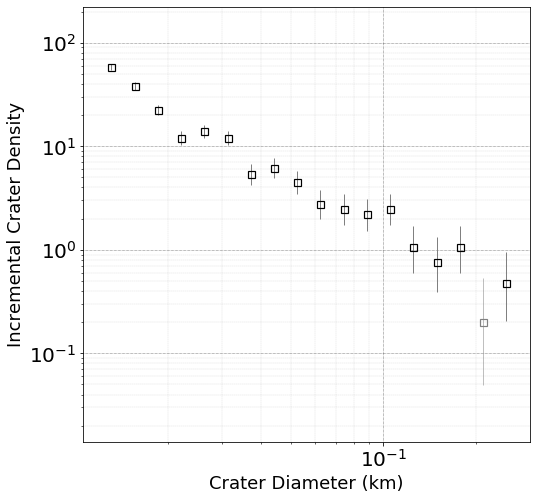

In [4]:
bin_width_exponent=0.25
plot_incremental_left(ds,area,bin_width_exponent=bin_width_exponent)

To help us more clearly see the equilibrium saturation inflection point, we plot the data using the cumulative unbinned plot type.  Here, we can see that the inflection point falls around ~D=0.1km, so we choose to use the final six bins from the incremental left plot to calculate the age, setting the num_bins_fitted parameter equal to 6.

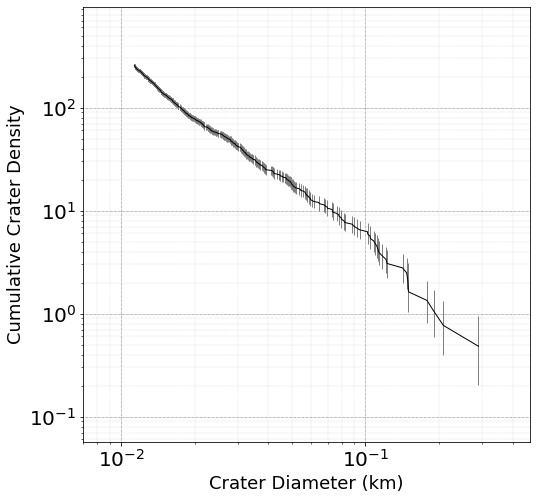

In [5]:
plot_cumulative_unbinned(ds,area)
num_bins_fitted = 6

At this point, we're ready to calculate the age distribution using the one-line function.

(1.6409345704836877, 2.101359943084406, 2.635698093126593)

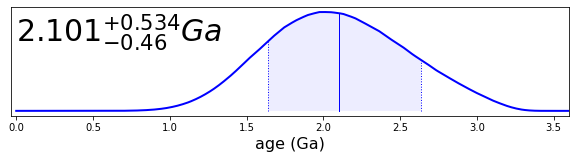

In [6]:
plot_age(ds, area, bin_width_exponent=bin_width_exponent, num_bins_fitted=num_bins_fitted)

To explain in more detail how this works, let's work through the process step by step.  In the next step, we calculate the underlying data from the incremental left plot.  This takes a bit longer than the plotting does because we produce numerical distributions with 100,000 points each for each bin.  The number of points in the numerical distributions can be adjusted for computational accuracy and speed.  On a rather old MacBook Pro, it takes a bit under 2 seconds to run.

In [7]:
t1=time.time()
binned_data = calc_incremental_left(ds,area,n_points=100000,bin_width_exponent=bin_width_exponent)
t2=time.time()
print('Done in: ' + str(round(t2-t1,5)) + ' s')

Done in: 1.90388 s


To visualize this calculation, we plot the PDFs of the cratering rate parameter, λ, in terms of craters per bin.  What λ describes is the likelihood distribution of different possible underlying cratering rates given the actual number of craters observed.  The shapes of these PDFs follow the percent-point function of the gamma distribution (a continuous extrapolation of the Poisson distribution).

In the left-hand plot, we show the PDFs for all the bins, with the ones we will use in black and the others in gray.  In the right-hand plot, we zoom in on the bins we will use.

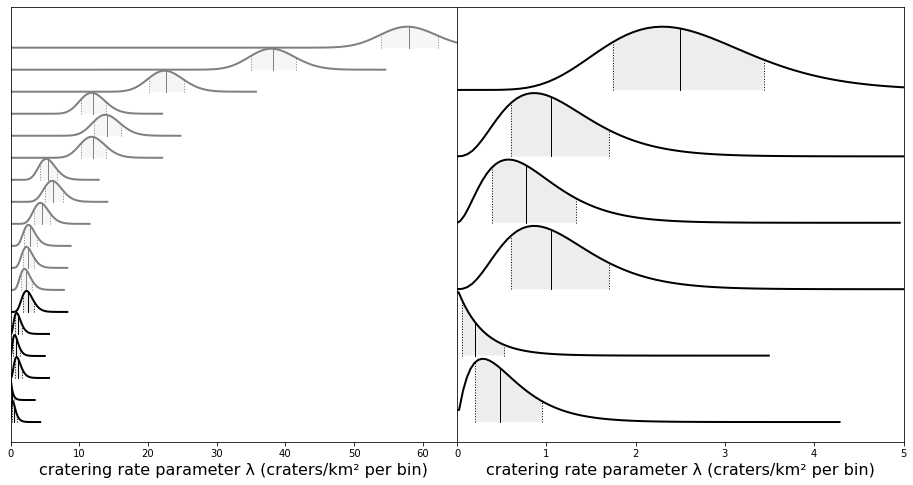

In [8]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0])):
    plot_dist(binned_data['ndist'][i],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,65])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('cratering rate parameter λ (craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
ax=fig.add_subplot(122)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_dist(binned_data['ndist'][i],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,5])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('cratering rate parameter λ (craters/km\N{SUPERSCRIPT TWO} per bin)',size=16)
plt.subplots_adjust(wspace=0, hspace=0)

Next, we calculate the distribution of different N(D=1km) projected cumulative count values for each bin, using the "new" Neukum Production Function as the assumed production function.  The reason we convert to N(1) counts is that the Neukum Chronology Function uses N(1) counts as its input.  We also have to convert to N(1) counts so that we can incorporate the information from the absense of craters larger than the largest bin.  This absence of craters must be compared against the cumulative, not the incremental left, version of the production function.

WARNING: This step assumes no shape uncertainty whatsoever in the Neukum Production Function.  This is a standard assumption, but in real life there is almost certainly some shape uncertainty in the Neukum Production Function.  Exactly how large this effect is is unknown.

In [9]:
binned_data = binned_data.assign(n1_dist=((binned_data['ndist']/(binned_data['D'].\
        apply(lambda d: npf_new_incremental_left(d,bin_width_exponent=bin_width_exponent))))*npf_new(1)))

Here, we visualize the calculated projected N(1) values.

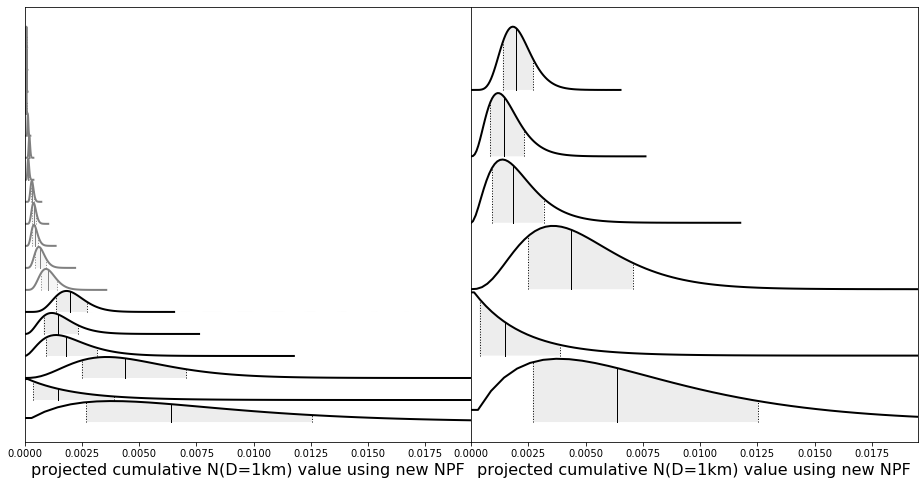

In [10]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0])):
    plot_dist(binned_data['n1_dist'][i],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
ax=fig.add_subplot(122)
color_list=['gray']*(binned_data.shape[0]-num_bins_fitted)+['black']*num_bins_fitted
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_dist(binned_data['n1_dist'][i],upshift=-1.05*i,ax=ax,color=color_list[i])
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)
plt.subplots_adjust(wspace=0, hspace=0)

Next, we convert our numerical distributions of N(1) values to PDFs.  Here, we choose to set the number of bins equal to 400.  This parameter should be adjusted depending on the data and the value of n_points used.  With higher n_points, more bins can be used to improve the N(1) resolution of the PDFs before there are numerical problems.

NOTE: This calculation could probably be better optimized numerically.

In [11]:
n_bins=400
max_val=max([np.percentile(n1_dist,99) for n1_dist in binned_data.iloc[-1*num_bins_fitted:]['n1_dist']])
density_pdf_list = [get_pdf(density_dist,n_bins=n_bins,max_val=max_val)[1] for density_dist in \
                    binned_data['n1_dist'][(-1*num_bins_fitted):]]

Next, we calculate the N(1) distribution associated with the observation of zero craters larger than the maximum diameter of our largest bin.  Because this is a cumulative observation of no craters larger than a certain diameter, we project this distribution to N(1) using the cumulative version of the "new" Neukum Production Function, not the incrememntal left version.  We first calculate the numerical distribution then the PDF.  Here we also calculate X_pdf, the values of N(1) corresponding to the relative probabilities.  The X_pdf must be the same for each PDF in order to multiply the PDFs together.

In [12]:
zero_dist=ig_ndist(0,n_points=10000)/area/npf_new(binned_data.iloc[-1]['D']*2**bin_width_exponent)*npf_new(1)
X_pdf,zero_pdf=get_pdf(zero_dist,n_bins=n_bins,max_val=max_val)

Then, we multiply these PDFs together to produce a posterior PDF showing the distribution of possible N(1) values.

In [13]:
Y_combined_pdf = np.prod(density_pdf_list,axis=0)*zero_pdf

Here, we visualize the multiplication of the N(1) distributions for each data bin used (black) together with the N(1) distribution for the absence of craters larger than the largest bin (gray).  In blue we have the final PDF.  Note how the specific shapes of these PDFs matter, leading to a quite different result than would be reached by just averaging the median values.

Text(0.5, 0, 'projected cumulative N(D=1km) value using new NPF')

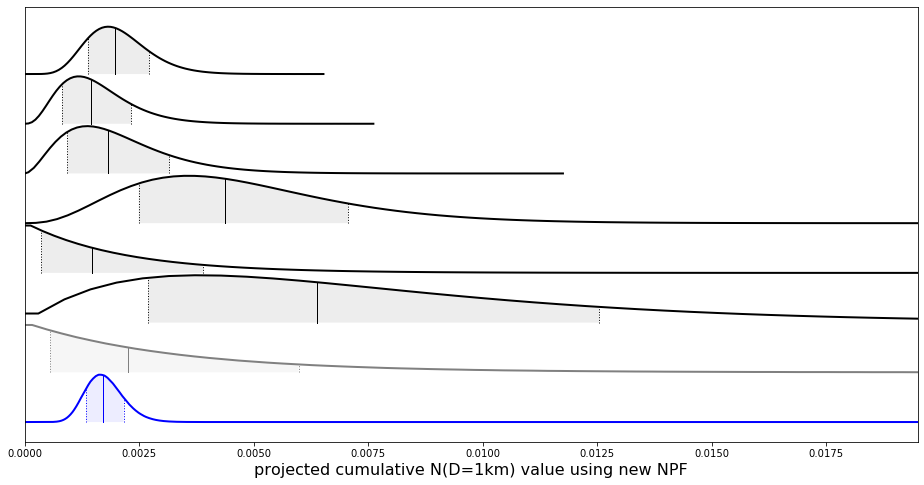

In [14]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
for i in list(range(binned_data.shape[0] - num_bins_fitted,binned_data.shape[0])):
    plot_dist(binned_data['n1_dist'][i],upshift=-1.05*i,ax=ax,color='black')
plot_dist(zero_dist,upshift=-1.05*binned_data.shape[0],ax=ax,color='gray')
plot_pdf(X_pdf,Y_combined_pdf,ax=ax,upshift=-1.05*(binned_data.shape[0]+1))
plt.xlim([0,0.0195])
plt.yticks([])
#plt.xticks(size=20)
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)

A visualization of just the final N(1) distribution.

Text(0.5, 0, 'projected cumulative N(D=1km) value using new NPF')

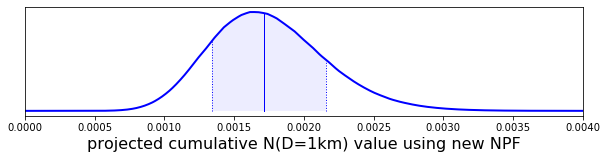

In [15]:
plot_pdf(X_pdf,Y_combined_pdf)
plt.yticks([])
plt.xlim([0,0.004])
plt.xlabel('projected cumulative N(D=1km) value using new NPF',size=16)

To show the final age distribution, we just plot it with the ncf_inv function applied to X_pdf.

Text(0, 0.7, '$2.101_{-0.46}^{+0.534}Ga$')

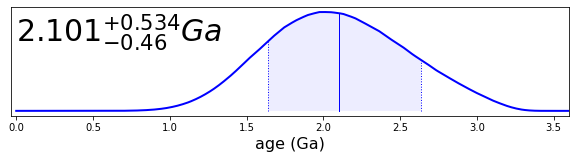

In [16]:
low,med,high=plot_pdf(ncf_inv(X_pdf),Y_combined_pdf)
plt.xlabel('age (Ga)',size=16)
plt.yticks([])
val999 = np.percentile(Y_combined_pdf.cumsum(),99.9)
idx=np.argmin(abs(Y_combined_pdf.cumsum()-val999))
age_max = ncf_inv(X_pdf[idx])
plt.xlim([-0.01*age_max,age_max])
plt.text(0,0.7,r'$'+str(round(med,3))+'_{-'+str(round(med-low,3))+'}^{+'+str(round(high-med,3))+'}Ga$',size=30)

The fit superimposed on the incremental left plot.  Note how the true fit is not exactly the best fit to the points.

(0.01, 100)

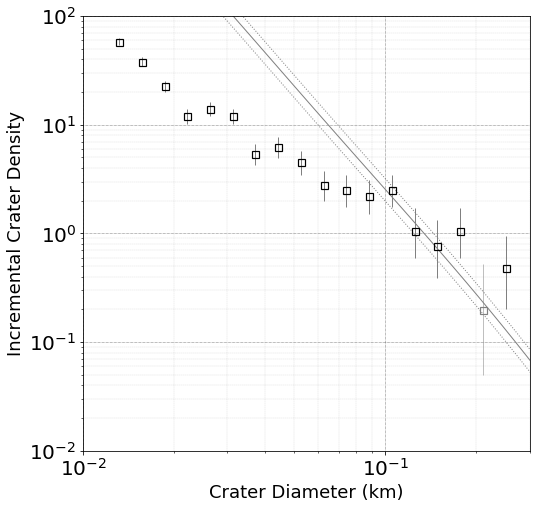

In [17]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
d = np.logspace(-2,0)
ax.plot(d,ncf(med)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray')
ax.plot(d,ncf(low)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray',linestyle=':')
ax.plot(d,ncf(high)/ncf(1)*npf_new_incremental_left(d,bin_width_exponent=0.25),'gray',linestyle=':')
plot_incremental_left(ds,area,ax=ax,bin_width_exponent=0.25)
plt.xlim(0.01,0.3)
plt.ylim(10**-2,10**2)

The fit superimposed on the unbinned cumulative plot.  Note how the true fit is not exactly the best fit to the points.

(0.01, 316.22776601683796)

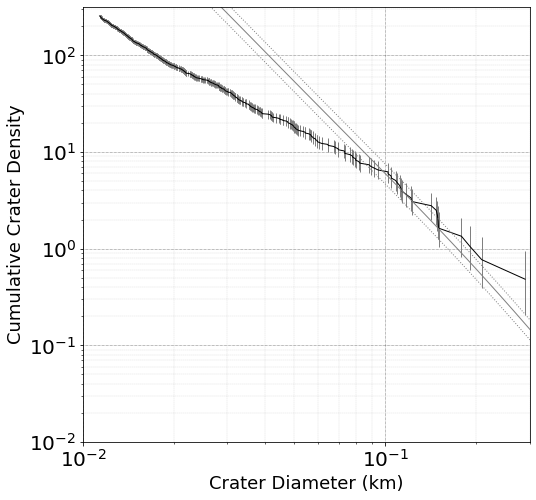

In [18]:
plot_cumulative_unbinned(ds,area)
d = np.logspace(-2,0)
plt.plot(d,ncf(med)/ncf(1)*npf_new(d),'gray')
plt.plot(d,ncf(low)/ncf(1)*npf_new(d),'gray',linestyle=':')
plt.plot(d,ncf(high)/ncf(1)*npf_new(d),'gray',linestyle=':')
plt.xlim(0.01,0.3)
plt.ylim(10**-2,10**2.5)

The fit superimposed on the differential plot.  Note how the true fit is not exactly the best fit to the points.

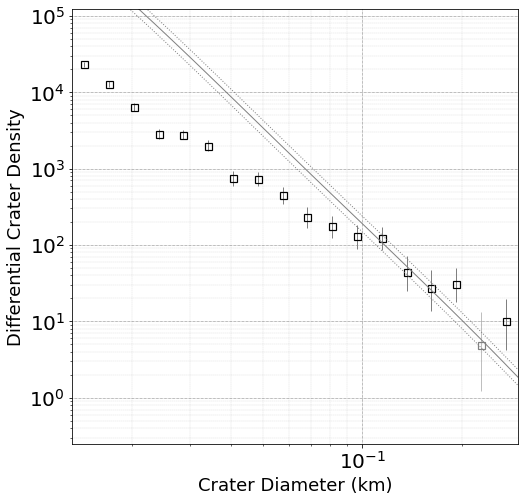

In [19]:
plot_differential(ds,area,bin_width_exponent=bin_width_exponent)
d = np.logspace(-2,0)
plt.plot(d,ncf(med)/ncf(1)*npf_new_differential(d),'gray')
plt.plot(d,ncf(low)/ncf(1)*npf_new_differential(d),'gray',linestyle=':')
plt.plot(d,ncf(high)/ncf(1)*npf_new_differential(d),'gray',linestyle=':')
# plt.xlim(0.01,1)
# plt.ylim(10**-3,10**5)